In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        print(f"Fitting toy MC bin no.{i}")
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0,output_dir='./stan_trash',show_progress=False)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

def fit_bin(nsamples,binnr): #fit only one bin
    #read data
    df=pd.read_csv(f"toybins/toybin{binnr:04d}.txt",sep="\t")
    df.columns=['pol','phi','weight']
    #these are prompt peak events
    prmpt=df.loc[df['weight']==1]
    prmpt=prmpt.reset_index(drop=True)
    #sideband
    side=df.loc[df['weight']!=1]
    side=side.reset_index(drop=True)
    nprmpt=len(prmpt)
    total_nside=(len(side))
    #weights used in the data, including 1--> exterminate 1
    weights=pd.unique(df['weight'].values)
    weights=np.array(weights[weights!=1])
    #sideband events are identified by the corresponding weights
    nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
    #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
    f=(nprmpt+np.sum(nside*weights))/nprmpt
    print(f)
    stan_data={
        'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
        'phi_prmpt':list(prmpt['phi'].values),
        'pol_prmpt':list(prmpt['pol'].values),
        'M':total_nside,#no. of sideband events and..
        'phi_side':list(side['phi'].values),
        'pol_side':list(side['pol'].values),
        'f':f #fraction of signal in prmpt peak
    }
    print(nprmpt, total_nside)
    #now the stan model and mcmc
    model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
    model.compile()
    fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
    summary=fitobj.summary()
    samples=fitobj.draws_pd()
    return samples,summary

In [4]:
dfs=fit(nsamples=5000,nbins=1,start=999)
diagnostics=dfs[0]
sigma=dfs[1]
#diagnostics.to_csv('toy_diagnostics.csv')
#sigma.to_csv('toy_sigma.csv')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.999
0.9499066666666666
375 289


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


,toybin0999
sigma_median,0.170000
mcse,0.001599
rhat,1.000000


In [5]:
dfs[2]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1.8000,0.03500,3.000,-7.300,-1.5000,2.5000,7500.00,100.00,1.0
sigma,0.1700,0.00120,0.240,-0.230,0.1700,0.5700,38000.00,520.00,1.0
a[1],0.0063,0.00029,0.060,-0.093,0.0065,0.1100,43165.00,585.00,1.0
a[2],-0.0820,0.00029,0.061,-0.180,-0.0820,0.0200,42579.00,577.00,1.0
a[3],-0.0170,0.00032,0.061,-0.120,-0.0170,0.0830,36086.00,489.00,1.0
a[4],0.0540,0.00030,0.061,-0.047,0.0530,0.1500,41047.00,556.00,1.0
b[1],-0.0490,0.00032,0.060,-0.150,-0.0490,0.0500,35511.00,481.00,1.0
b[2],-0.0300,0.00031,0.061,-0.130,-0.0290,0.0700,39514.00,536.00,1.0
b[3],-0.0750,0.00030,0.060,-0.170,-0.0750,0.0240,40307.00,546.00,1.0


In [5]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

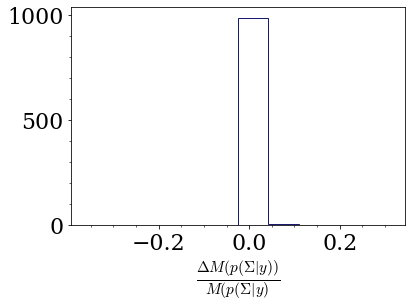

In [6]:
rel_err=[(diagnostics_df[f'toybin{i:04d}']['mcse']/diagnostics_df[f'toybin{i:04d}']['sigma_median']) for i in range(len(diagnostics_df.columns))]
plt.hist(rel_err,histtype='step',color='midnightblue')
plt.xlabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
plt.grid(False)
#plt.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [7]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)))

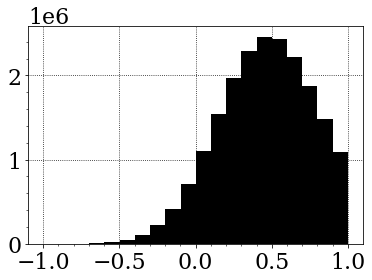

In [8]:
plt.hist(all_sigmas,bins=20)
plt.show()